In [49]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_real_n_warehouses_n_stores"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']
    if 'master_n_warehouses' in reference_row:
        out_row['master_n_warehouses'] = reference_row['master_n_warehouses']

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    64: "#1f77b4",     # Blue
    288: "#ff7f0e",    # Orange
}

marker_scheme = {
    64: "o",           # Circle
    288: "s",          # Square
}

linestyle_scheme = {
    "Vanilla": "-",      # Solid
    "GNN": "--",               # Dashed
}

# Define paths for each architecture
architectures = {
    "Vanilla": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/data_driven_net_n_warehouses_real',
    "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
    "Just-In-Time": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/just_in_time_real',
}

# Define configs for different settings
configs = [
    "n_warehouse_21_2_real_lost_demand",
    "n_warehouse_21_3_real_lost_demand",
    "n_warehouse_21_4_real_lost_demand",
    "n_warehouse_21_5_real_lost_demand"
]

# Map configs to their warehouses values for plotting
config_to_warehouses = {
    "n_warehouse_21_2_real_lost_demand": 2,
    "n_warehouse_21_3_real_lost_demand": 3,
    "n_warehouse_21_4_real_lost_demand": 4,
    "n_warehouse_21_5_real_lost_demand": 5
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
sample_sizes = [64, 288]

dfs = []
jit_dfs = []

# Create dataframes for each architecture and sample size, passing all configs at once
for arch_name, path in architectures.items():
    if arch_name == "Just-In-Time":
        for sample_size in sample_sizes:
            jit_df = results_interpretor.make_table(
                {1: path},
                {'config': configs, 'train_dev_sample_and_batch_size': [sample_size]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25
            )
            if not jit_df.empty:
                jit_df.insert(2, 'Architecture Class', arch_name)
                jit_df.insert(1, 'hyperparam_name', arch_name)
                jit_df['n_warehouses'] = jit_df['config'].map(config_to_warehouses)
                jit_df['train_dev_sample_and_batch_size'] = sample_size
                jit_dfs.append(jit_df)
    else:
        for sample_size in sample_sizes:
            if arch_name == "GNN Bottleneck" and sample_size == 64:
                df = results_interpretor.make_table(
                    {1: path},
                    {
                        'train_dev_sample_and_batch_size': [sample_size],
                        'config': configs,
                        'test_n_samples': [sample_size],
                        "train_batch_size": [72]
                    },
                    default_condition_setter, custom_data_filler,
                    sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25
                )
            else:
                df = results_interpretor.make_table(
                    {1: path},
                    {
                        'train_dev_sample_and_batch_size': [sample_size],
                        'config': configs,
                        'test_n_samples': [sample_size]
                    },
                    default_condition_setter, custom_data_filler,
                    sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25
                )
            if df.empty:
                continue

            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['train_dev_sample_and_batch_size'] = sample_size
            df['n_warehouses'] = df['config'].map(config_to_warehouses)
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)
jit_df = pd.concat(jit_dfs, ignore_index=True) if jit_dfs else pd.DataFrame()


In [51]:
import numpy as np

# Prepare mapping for sorting architecture class
def arch_sort_key(x):
    return 0 if x == "GNN" else 1

# Prepare the new DataFrame
rows = []
for _, row in df.iterrows():
    n_warehouses = row.get('n_warehouses', '-')
    train_scenarios = row.get('train_dev_sample_and_batch_size', '-')
    arch_class = row.get('Architecture Class', '-')
    learning_rate = row.get('Learning Rate', '-')
    units_per_layer = row.get('master_n_warehouses', '-')
    train_loss = row.get('Train Loss', '-')
    dev_loss = row.get('Dev Loss', '-')
    test_loss = row.get('Test Loss', '-')
    config = row.get('config', None)

    # Negate and round losses if present, else '-'
    train_profit = round(-train_loss, 2) if train_loss not in [None, '-'] and not pd.isna(train_loss) else '-'
    dev_profit = round(-dev_loss, 2) if dev_loss not in [None, '-'] and not pd.isna(dev_loss) else '-'
    test_profit = round(-test_loss, 2) if test_loss not in [None, '-'] and not pd.isna(test_loss) else '-'

    # Test profit relative to JIT
    if config in config_to_warehouses:
        n_stores = config_to_warehouses[config]
    else:
        n_stores = n_warehouses
    jit_loss = jit_losses.get((config, train_scenarios), None)
    if jit_loss is not None and test_loss not in [None, '-'] and not pd.isna(test_loss):
        rel_gap = round((-test_loss / -jit_loss) * 100 , 2)
    else:
        rel_gap = '-'

    rows.append({
        "Number of warehouses": n_warehouses,
        "Training scenarios (#)": train_scenarios,
        "Architecture Class": arch_class,
        "Learning rate": learning_rate if learning_rate not in [None, '-'] and not pd.isna(learning_rate) else '-',
        "Units per layer (#)": units_per_layer if units_per_layer not in [None, '-'] and not pd.isna(units_per_layer) else '-',
        "Train profit": train_profit,
        "Dev profit": dev_profit,
        "Test profit": test_profit,
        "Test profit relative to Just-in-time (%)": rel_gap,
        "_raw_test_loss": test_loss if test_loss not in [None, '-'] and not pd.isna(test_loss) else np.inf,  # for picking best
    })

# Create DataFrame
table_df = pd.DataFrame(rows)

# For each number of warehouses, pick the row with lowest test loss (before rounding)
def bold_best_test_profit(group):
    if group['_raw_test_loss'].isnull().all():
        return group
    min_idx = group['_raw_test_loss'].astype(float).idxmin()
    # Only bold if not '-'
    if group.loc[min_idx, "Test profit"] != '-':
        val = group.loc[min_idx, "Test profit"]
        group.at[min_idx, "Test profit"] = r"\textbf{" + str(val) + "}"
    return group

table_df = table_df.groupby("Number of warehouses", group_keys=False).apply(bold_best_test_profit)

# Remove helper column
table_df = table_df.drop(columns=['_raw_test_loss'])

# Sorting: by Number of warehouses, then Training scenarios, then Architecture Class (GNN first, then Vanilla)
def safe_int(x):
    try:
        return int(x)
    except:
        return 1e9

table_df = table_df.copy()
table_df['__n_warehouses'] = table_df['Number of warehouses'].apply(safe_int)
table_df['__train_scenarios'] = table_df['Training scenarios (#)'].apply(safe_int)
table_df['__arch_sort'] = table_df['Architecture Class'].apply(arch_sort_key)
table_df = table_df.sort_values(['__n_warehouses', '__train_scenarios', '__arch_sort'])
table_df = table_df.drop(columns=['__n_warehouses', '__train_scenarios', '__arch_sort'])

print(table_df.to_string(index=False))

 Number of warehouses  Training scenarios (#) Architecture Class  Learning rate Units per layer (#)  Train profit  Dev profit     Test profit Test profit relative to Just-in-time (%)
                    2                      64                GNN         0.0001                   -        537.76      519.41          466.74                                        -
                    2                      64            Vanilla         0.0001               512.0        558.22      505.65          445.45                                        -
                    2                     288                GNN         0.0010                   -        611.75      585.04 \textbf{534.28}                                    82.23
                    2                     288            Vanilla         0.0001               256.0        613.88      570.10           516.3                                    79.46
                    3                      64                GNN         0.0001      

/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_98792/3463789891.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{534.28}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group.at[min_idx, "Test profit"] = r"\textbf{" + str(val) + "}"
/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_98792/3463789891.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{536.15}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group.at[min_idx, "Test profit"] = r"\textbf{" + str(val) + "}"
/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_98792/3463789891.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{537.8}' has 

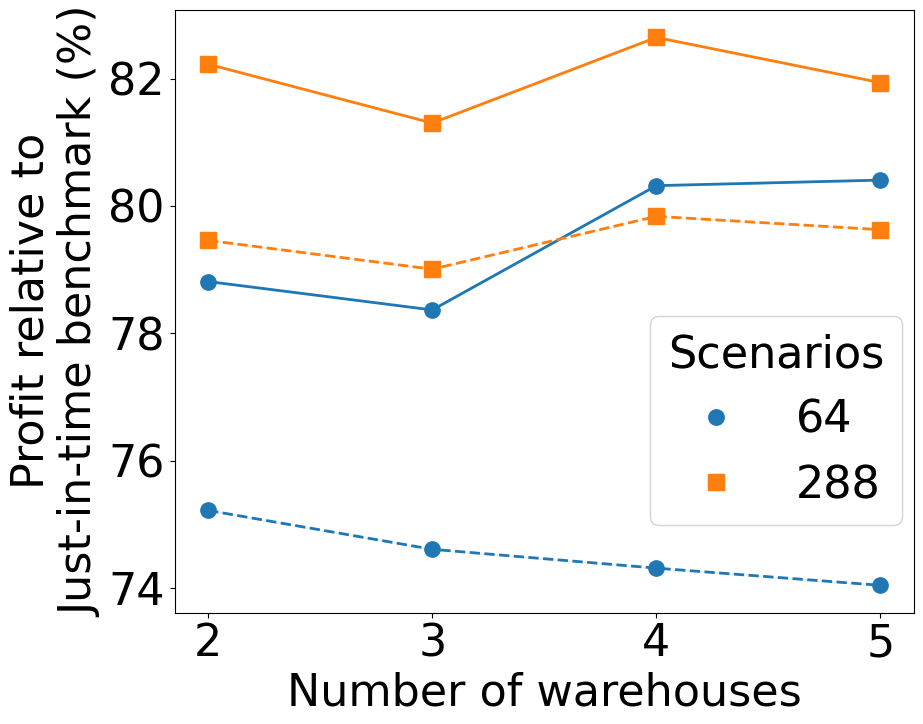

In [ ]:

# Find Just-In-Time loss for each config and sample size
jit_losses = {}
for config in configs:
    for sample_size in sample_sizes:
        jit_data = jit_df[(jit_df['config'] == config) & 
                          (jit_df['train_dev_sample_and_batch_size'] == sample_size)]
        if not jit_data.empty:
            jit_loss = jit_data['Test Loss'].min()
            jit_losses[(config, sample_size)] = jit_loss

# Calculate loss ratio compared to Just-In-Time
stats_by_arch_sample_and_config = {}
for config in configs:
    config_data = df[df['config'] == config].copy()
    if config_data.empty:
        continue
    for sample_size in sample_sizes:
        if (config, sample_size) not in jit_losses:
            continue
        jit_loss = jit_losses[(config, sample_size)]
        sample_data = config_data[config_data['train_dev_sample_and_batch_size'] == sample_size].copy()
        if sample_data.empty:
            continue
        sample_data.loc[:, 'Loss Ratio'] = sample_data['Test Loss'] / jit_loss
        for arch in sample_data['Architecture Class'].unique():
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_config:
                stats_by_arch_sample_and_config[key] = []
            arch_data = sample_data[sample_data['Architecture Class'] == arch]
            if not arch_data.empty:
                ratios = arch_data['Loss Ratio'].to_numpy()
                mean_percentage = np.mean(ratios * 100)
                std_percentage = np.std(ratios * 100)
                ci_95 = 1.96 * std_percentage / np.sqrt(len(ratios))
                stats_by_arch_sample_and_config[key].append({
                    'config': config,
                    'n_warehouses': config_to_warehouses[config],
                    'mean_percentage': mean_percentage,
                    'ci_lower': mean_percentage - ci_95,
                    'ci_upper': mean_percentage + ci_95
                })

FONTSIZE = 32
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Color and marker schemes for 64 and 288
color_scheme = {
    64: "#1f77b4",   # blue
    288: "#ff7f0e",  # orange
}
marker_scheme = {
    64: "o",         # circle
    288: "s",        # rectangle (square)
}
marker_size = 11
line_width = 2

# Line style for arch
linestyle_scheme = {
    "GNN": "solid",
    "Vanilla": "dashed"
}

# Plot lines, sort by arch (GNN first), then by sample size (low to high)
arch_order = ["GNN", "Vanilla"]
sample_order = sorted(color_scheme.keys())
for arch in arch_order:
    for sample_size in sample_order:
        key = (arch, sample_size)
        stats = stats_by_arch_sample_and_config.get(key, [])
        stats_df = pd.DataFrame(stats)
        if not stats_df.empty:
            stats_df = stats_df.sort_values('n_warehouses')
            n_warehouses_array = stats_df['n_warehouses'].to_numpy()
            mean_percentage_array = stats_df['mean_percentage'].to_numpy()
            ci_lower_array = stats_df['ci_lower'].to_numpy()
            ci_upper_array = stats_df['ci_upper'].to_numpy()
            plt.plot(
                n_warehouses_array,
                mean_percentage_array,
                marker=marker_scheme[sample_size],
                color=color_scheme[sample_size],
                linestyle=linestyle_scheme[arch],
                markersize=marker_size,
                linewidth=line_width,
                label=f"{arch}, {sample_size}"
            )
            plt.fill_between(
                n_warehouses_array,
                ci_lower_array,
                ci_upper_array,
                color=color_scheme[sample_size],
                alpha=0.1
            )

plt.xlabel('Number of warehouses', fontsize=FONTSIZE)
plt.ylabel('Profit relative to\nJust-in-time benchmark (%)', fontsize=FONTSIZE)

x_ticks = sorted(list(config_to_warehouses.values()))
plt.xticks(x_ticks, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# Legend handles for architectures (GNN above Vanilla)
arch_lines = [
    plt.Line2D([0], [0], color='black', linestyle=linestyle_scheme[arch], linewidth=line_width, label=arch)
    for arch in arch_order
]
# Legend handles for sample sizes, from low to high
sample_patches = [
    plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], linestyle='none',
               label=f'{size}', markersize=marker_size, linewidth=0)
    for size in sample_order
]

# legend1 = plt.legend(
#     handles=arch_lines,
#     bbox_to_anchor=(0.99, 0.5),
#     loc='upper right',
#     fontsize=FONTSIZE,
#     borderaxespad=0.1,
#     framealpha=0.6
# )
# plt.gca().add_artist(legend1)

legend2 = plt.legend(
    handles=sample_patches,
    title='Scenarios',
#     bbox_to_anchor=(0.22, 0.5),
#     loc='upper left',
    bbox_to_anchor=(0.99, 0.5),
    loc='upper right',
    fontsize=FONTSIZE,
    borderaxespad=0.1,
    framealpha=0.6
)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

plt.tight_layout()
plt.savefig('/user/ml4723/Prj/NIC/Plots/sample_efficiency_MWMS_real.pdf', bbox_inches='tight')
plt.show()

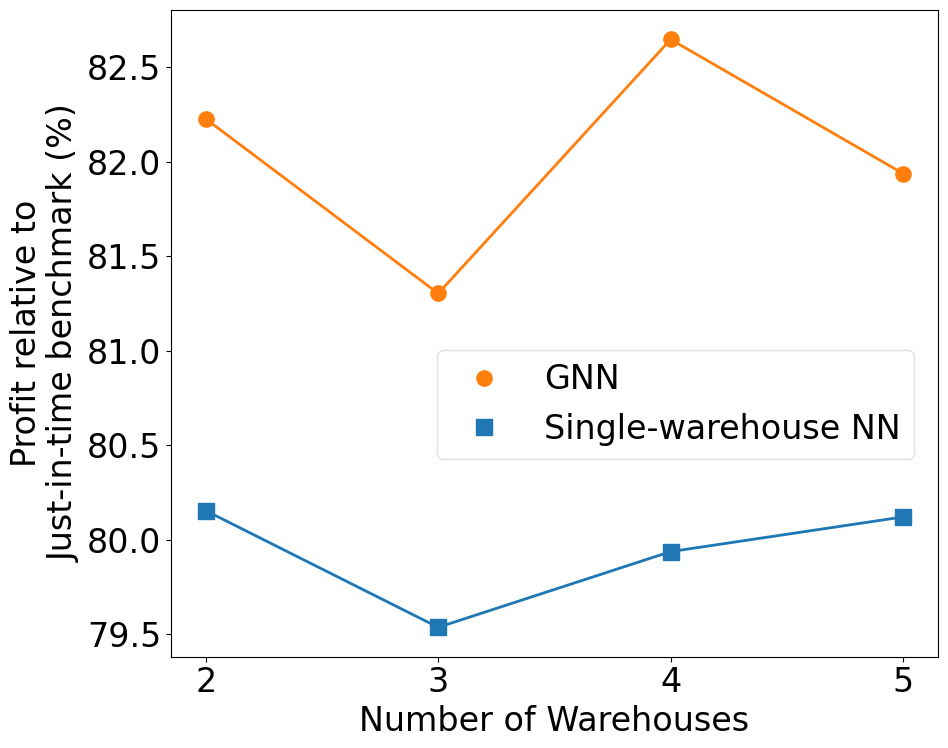

In [42]:
FONTSIZE = 24
MARKERSIZE = 11
LINEWIDTH = 2
FIGSIZE = (10, 8)

testset_name = "finals_real_n_warehouses_n_stores"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

color_scheme = {
    "GNN": "#ff7f0e",  # orange
    "Single-warehouse NN": "#1f77b4",  # blue
}

marker_scheme = {
    "GNN": "o",  # circle
    "Single-warehouse NN": "s",  # rectangle (square)
}

architectures = {
    "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
    "Single-warehouse NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_best',
    "Just-In-Time": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/just_in_time_real',
}

configs = [
    "n_warehouse_21_2_real_lost_demand",
    "n_warehouse_21_3_real_lost_demand",
    "n_warehouse_21_4_real_lost_demand",
    "n_warehouse_21_5_real_lost_demand"
]

config_to_warehouses = {
    "n_warehouse_21_2_real_lost_demand": 2,
    "n_warehouse_21_3_real_lost_demand": 3,
    "n_warehouse_21_4_real_lost_demand": 4,
    "n_warehouse_21_5_real_lost_demand": 5
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
sample_size = 288

dfs = []
jit_dfs = []

for arch_name, path in architectures.items():
    for config in configs:
        if arch_name == "Just-In-Time":
            jit_df = results_interpretor.make_table({1: path},
                {'config': [config], 'train_dev_sample_and_batch_size': [sample_size]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
            if not jit_df.empty:
                jit_df.insert(2, 'Architecture Class', arch_name)
                jit_df.insert(1, 'hyperparam_name', arch_name)
                jit_df['config'] = config
                jit_df['n_warehouses'] = config_to_warehouses[config]
                jit_dfs.append(jit_df)
        else:
            if arch_name == "Single-warehouse NN":
                config_read = config + "_best"
            else:
                config_read = config
            df = results_interpretor.make_table({1: path},
                {'train_dev_sample_and_batch_size': [sample_size],
                 'config': [config_read]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
            if df.empty:
                continue
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['train_dev_sample_and_batch_size'] = sample_size
            df['config'] = config
            df['n_warehouses'] = config_to_warehouses[config]
            dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
jit_df = pd.concat(jit_dfs, ignore_index=True) if jit_dfs else pd.DataFrame()

jit_losses = {}
for config in configs:
    jit_data = jit_df[jit_df['config'] == config]
    if not jit_data.empty:
        jit_loss = jit_data['Test Loss'].min()
        jit_losses[config] = jit_loss

stats_by_arch_and_config = {}
for config in configs:
    config_data = df[df['config'] == config].copy()
    if config_data.empty or config not in jit_losses:
        continue
    jit_loss = jit_losses[config]
    config_data.loc[:, 'Loss Ratio'] = config_data['Test Loss'] / jit_loss
    for arch in config_data['Architecture Class'].unique():
        if arch not in color_scheme:
            continue
        key = arch
        if key not in stats_by_arch_and_config:
            stats_by_arch_and_config[key] = []
        arch_data = config_data[config_data['Architecture Class'] == arch]
        if not arch_data.empty:
            ratios = arch_data['Loss Ratio'].to_numpy()
            mean_percentage = np.mean(ratios * 100)
            std_percentage = np.std(ratios * 100)
            ci_95 = 1.96 * std_percentage / np.sqrt(len(ratios))
            stats_by_arch_and_config[key].append({
                'config': config,
                'n_warehouses': config_to_warehouses[config],
                'mean_percentage': mean_percentage,
                'ci_lower': mean_percentage - ci_95,
                'ci_upper': mean_percentage + ci_95
            })

plt.figure(figsize=FIGSIZE)
plt.rcParams.update({'font.size': FONTSIZE})

for arch, stats in stats_by_arch_and_config.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        stats_df = stats_df.sort_values('n_warehouses')
        n_warehouses_array = stats_df['n_warehouses'].to_numpy()
        mean_percentage_array = stats_df['mean_percentage'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        plt.plot(
            n_warehouses_array,
            mean_percentage_array,
            marker=marker_scheme[arch],
            color=color_scheme[arch],
            markersize=MARKERSIZE,
            linewidth=LINEWIDTH
        )
        plt.fill_between(
            n_warehouses_array,
            ci_lower_array,
            ci_upper_array,
            color=color_scheme[arch],
            alpha=0.1
        )

arch_patches = [
    plt.Line2D([0], [0], color=color_scheme[arch], marker=marker_scheme[arch],
               linestyle='None', label=arch, markersize=MARKERSIZE, linewidth=0)
    for arch in color_scheme.keys()
]

plt.xlabel('Number of Warehouses', fontsize=FONTSIZE)
plt.ylabel('Profit relative to\nJust-in-time benchmark (%)', fontsize=FONTSIZE)

x_ticks = sorted(list(config_to_warehouses.values()))
plt.xticks(x_ticks, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

plt.legend(
    handles=arch_patches,
    bbox_to_anchor=(0.99, 0.5),
    loc='upper right',
    fontsize=FONTSIZE,
    framealpha=0.6
)

plt.tight_layout()
plt.savefig('/user/ml4723/Prj/NIC/Plots/flexibility.pdf', bbox_inches='tight')
plt.show()

In [47]:
# Calculate and print a table of excess relative profit of GNN compared to Single-warehouse NN

single_warehouse_key = 'Single-warehouse NN'
gnn_key = 'GNN'

single_warehouse_stats = stats_by_arch_and_config.get(single_warehouse_key, [])
gnn_stats = stats_by_arch_and_config.get(gnn_key, [])

single_warehouse_df = pd.DataFrame(single_warehouse_stats)
gnn_df = pd.DataFrame(gnn_stats)

if not single_warehouse_df.empty and not gnn_df.empty:
    single_warehouse_df = single_warehouse_df.sort_values('n_warehouses')
    gnn_df = gnn_df.sort_values('n_warehouses')

    # Map n_warehouses to mean_percentage for single-warehouse NN
    single_warehouse_map = dict(zip(single_warehouse_df['n_warehouses'], single_warehouse_df['mean_percentage']))

    table_rows = []
    for _, row in gnn_df.iterrows():
        n_wh = row['n_warehouses']
        gnn_val = row['mean_percentage']
        baseline = single_warehouse_map.get(n_wh, None)
        if baseline is not None:
            excess = (gnn_val - baseline) / baseline * 100
            table_rows.append({
                'n_warehouses': n_wh,
                'GNN': gnn_val,
                'SingleWarehouseNN': baseline,
                'ExcessRelativeProfit': excess
            })

    table_df = pd.DataFrame(table_rows)
    print(table_df.to_string(index=False))
else:
    print("GNN or Single-warehouse NN results missing.")

 n_warehouses       GNN  SingleWarehouseNN  ExcessRelativeProfit
            2 82.227427          80.153175              2.587860
            3 81.303172          79.535459              2.222547
            4 82.648173          79.936370              3.392452
            5 81.937829          80.120013              2.268866


In [ ]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_real_n_warehouses_n_stores"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme and line styles
color_scheme = {
    "GNN": "#1f77b4",          # Blue
    "GNN_fastest": "#ff7f0e",  # Orange
    "GNN_cheapest": "#2ca02c", # Green
    "GNN_best": "#d62728",     # Red
}

marker_scheme = {
    "GNN": "o",                # Circle
    "GNN_fastest": "s",        # Square
    "GNN_cheapest": "^",       # Triangle
    "GNN_best": "D",           # Diamond
}

# Define paths for each architecture
architectures = {
    "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
    "GNN_fastest": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_fastest',
    "GNN_cheapest": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_cheapest',
    "GNN_best": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_best',
    "Just-In-Time": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/just_in_time_real',
}

# Define configs for different settings
configs = [
    "n_warehouse_21_2_real_lost_demand",
    "n_warehouse_21_3_real_lost_demand",
    "n_warehouse_21_4_real_lost_demand",
    "n_warehouse_21_5_real_lost_demand"
]

# Map configs to their warehouses values for plotting
config_to_warehouses = {
    "n_warehouse_21_2_real_lost_demand": 2,
    "n_warehouse_21_3_real_lost_demand": 3,
    "n_warehouse_21_4_real_lost_demand": 4,
    "n_warehouse_21_5_real_lost_demand": 5
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
sample_size = 288

dfs = []
jit_dfs = []

# Create dataframes for each architecture and config
for arch_name, path in architectures.items():
    for config in configs:
        if arch_name == "Just-In-Time":
            # For Just-In-Time benchmark
            jit_df = results_interpretor.make_table({1: path},
                {'config': [config], 'train_dev_sample_and_batch_size': [sample_size]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
            if not jit_df.empty:
                jit_df.insert(2, 'Architecture Class', arch_name)
                jit_df.insert(1, 'hyperparam_name', arch_name)
                jit_df['config'] = config
                jit_df['n_warehouses'] = config_to_warehouses[config]
                jit_dfs.append(jit_df)
        else:
            # For other architectures
            if arch_name == "GNN_best":
                config_read = config + "_best"
            else:
                config_read = config
            df = results_interpretor.make_table({1: path},
                {'train_dev_sample_and_batch_size': [sample_size],
                 'config': [config_read]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['train_dev_sample_and_batch_size'] = sample_size
            df['config'] = config
            df['n_warehouses'] = config_to_warehouses[config]
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)
jit_df = pd.concat(jit_dfs, ignore_index=True) if jit_dfs else pd.DataFrame()

# Find Just-In-Time loss for each config
jit_losses = {}
for config in configs:
    jit_data = jit_df[jit_df['config'] == config]
    if not jit_data.empty:
        jit_loss = jit_data['Test Loss'].min()
        jit_losses[config] = jit_loss

# Calculate loss ratio compared to Just-In-Time
stats_by_arch_and_config = {}
for config in configs:
    config_data = df[df['config'] == config].copy()
    
    if config_data.empty or config not in jit_losses:
        continue
    
    jit_loss = jit_losses[config]
    config_data.loc[:, 'Loss Ratio'] = config_data['Test Loss'] / jit_loss
    
    for arch in config_data['Architecture Class'].unique():
        key = arch
        if key not in stats_by_arch_and_config:
            stats_by_arch_and_config[key] = []
            
        arch_data = config_data[config_data['Architecture Class'] == arch]
        if not arch_data.empty:
            ratios = arch_data['Loss Ratio'].to_numpy()
            # Convert ratio to percentage (ratio - 1) * 100
            mean_percentage = np.mean(ratios * 100)
            std_percentage = np.std(ratios * 100)
            ci_95 = 1.96 * std_percentage / np.sqrt(len(ratios))
            stats_by_arch_and_config[key].append({
                'config': config,
                'n_warehouses': config_to_warehouses[config],
                'mean_percentage': mean_percentage,
                'ci_lower': mean_percentage - ci_95,
                'ci_upper': mean_percentage + ci_95
            })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch, stats in stats_by_arch_and_config.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Sort by number of warehouses for proper x-axis ordering
        stats_df = stats_df.sort_values('n_warehouses')
        
        # Convert pandas series to numpy arrays before plotting
        n_warehouses_array = stats_df['n_warehouses'].to_numpy()
        mean_percentage_array = stats_df['mean_percentage'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(n_warehouses_array, mean_percentage_array,
                marker=marker_scheme[arch],
                color=color_scheme[arch],
                markersize=8)
        
        plt.fill_between(n_warehouses_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[arch],
                        alpha=0.1)

# Create legend entries for architectures
arch_patches = [plt.Line2D([0], [0], color=color_scheme[arch], marker=marker_scheme[arch], 
                          linestyle='-', label=arch, markersize=8)
               for arch in color_scheme.keys()]

plt.xlabel('Number of Warehouses', fontsize=FONTSIZE)
plt.ylabel('Profit relative to Just-In-Time benchmark(%)', fontsize=FONTSIZE)
plt.grid(True)

# Set x-ticks to show only number of warehouses
x_ticks = sorted(list(config_to_warehouses.values()))
plt.xticks(x_ticks, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# Create legend
plt.legend(handles=arch_patches, 
          bbox_to_anchor=(0.99, 1),
          loc='upper right', 
          fontsize=FONTSIZE)

plt.tight_layout()
plt.show()

In [6]:
print(df.to_string())

    # of stores hyperparam_name  train_dev_sample_and_batch_size Architecture Class                             config  Learning Rate  Train Loss    Dev Loss   Test Loss  # of runs                                                                                                                                                                                                                                                                 path  n_warehouses
0             1             GNN                              288                GNN  n_warehouse_21_2_real_lost_demand         0.0010 -611.754805 -585.043588 -534.281305          9  /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_real_n_warehouses_n_stores/GNN_real_selfloop/run_2025-05-16_12-58-41/run_04c58_00004_4_config=n_warehouse_21_2_real_lost_demand,early_stop_check_epochs=10,learning_rate=0.0010,n_MP=2,repeats=1,stop_i_2025-05-16_12-58-41             2
1             1             GNN                          